In [2]:
import importlib
from collections import OrderedDict

for pkg in ["pandas", "matplotlib", "seaborn", "wandb"]:
    spec = importlib.util.find_spec(pkg)
    print(f"{pkg}: {'FOUND ✅' if spec is not None else 'NOT FOUND ❌'}")


pandas: FOUND ✅
matplotlib: FOUND ✅
seaborn: FOUND ✅
wandb: FOUND ✅


In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")  # nicer plots



# Load WANDB_API_KEY from your file
env_path = "/Users/skothare/python/IDL_Fall2025/IDL-FInalProjectPlotting/wandb.env"  

if os.path.exists(env_path):
    with open(env_path) as f:
        for line in f:
            key, value = line.strip().split("=")
            os.environ[key] = value

print("Loaded WANDB_API_KEY:", "WANDB_API_KEY" in os.environ)

wandb.login(key=os.environ["WANDB_API_KEY"])

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/skothare/.netrc


Loaded WANDB_API_KEY: True


wandb: Currently logged in as: ssk-phl (Diffusion-F25DL_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
from collections import OrderedDict

run_paths = OrderedDict({
    "ddpm+vae"      : "Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x",
    "ddpm+cfg"      : "Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b",
    "ddpm+vae+cfg"  : "Diffusion-F25DL_Project/ddpm/aujkiwqx",
    "ddpm"          : "Diffusion-F25DL_Project/ddpm/pu8h7znt",
    "ddim"          : "Diffusion-F25DL_Project/ddim/2fcddv4m",
    "ddim+vae+cfg"  : "Diffusion-F25DL_Project/ddim/ku8yhzgf",
    # add more here if you want (e.g., "ddim+vae": ".../runid")
})


In [17]:


api = wandb.Api()

path = "Diffusion-F25DL_Project/ddim/2fcddv4m"   # e.g. the ddim run
run = api.run(path)

rows = []
for row in run.scan_history():   # full, unsampled history
    rows.append(row)

hist = pd.DataFrame(rows)
print(hist.columns)
hist.head()


Index(['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch',
       'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean',
       'is_std'],
      dtype='object')


,_step,loss,_runtime,_timestamp,lr,epoch,train_loss_epoch_avg,val_loss,gen_images,fid,is_mean,is_std
0,0,0.998215,2.514087,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.551881,25.564585,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.316400,48.566823,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.232149,71.503153,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.188505,94.378534,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
api = wandb.Api()

all_runs = {}

for label, path in run_paths.items():
    print(f"Fetching run: {label} -> {path}")
    run = api.run(path)

    # 1) get FULL history (no sampling)
    rows = []
    for row in run.scan_history():   # no keys filter so we don't drop anything
        rows.append(row)
    hist = pd.DataFrame(rows)

    print("  columns:", list(hist.columns))

    # 2) make sure we have an epoch-like column
    if "epoch" in hist.columns:
        epoch_col = "epoch"
    elif "_step" in hist.columns:
        epoch_col = "_step"
    else:
        print(f"  ⚠️ No 'epoch' or '_step' column in {path}, skipping")
        continue

    # 3) keep just what we need
    wanted_cols = [epoch_col, "fid", "is_mean", "is_std"]
    cols_present = [c for c in wanted_cols if c in hist.columns]

    df = hist[cols_present].copy()
    df = df.dropna(subset=[epoch_col])        # drop rows where epoch is NaN
    df = df[df["fid"].notna() | df["is_mean"].notna()]  # keep rows with metrics

    # normalize column name to 'epoch'
    if epoch_col != "epoch":
        df = df.rename(columns={epoch_col: "epoch"})

    df["model"] = label
    all_runs[label] = df

len(all_runs), list(all_runs.keys())


Fetching run: ddpm+vae -> Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']
Fetching run: ddpm+cfg -> Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']
Fetching run: ddpm+vae+cfg -> Diffusion-F25DL_Project/ddpm/aujkiwqx
  columns: ['_timestamp', 'lr', 'train_loss_epoch_avg', 'fid', 'loss', 'is_mean', 'val_loss', '_step', 'gen_images', 'epoch', 'is_std', '_runtime']
Fetching run: ddpm -> Diffusion-F25DL_Project/ddpm/pu8h7znt
  columns: ['lr', 'is_mean', 'val_loss', '_timestamp', 'fid', 'loss', 'epoch', '_runtime', '_step', 'is_std', 'gen_images', 'train_loss_epoch_avg']
Fetching run: ddim -> Diffusion-F25DL_Project/ddim/2fcddv4m
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'tra

(6, ['ddpm+vae', 'ddpm+cfg', 'ddpm+vae+cfg', 'ddpm', 'ddim', 'ddim+vae+cfg'])

In [19]:
for name, path in run_paths.items():
    run = api.run(path)
    df = run.history()  # no column filter on purpose
    print(f"\n=== {name} ({path}) ===")
    print(df.columns.tolist()[:40])  # show first ~40 columns



=== ddpm+vae (Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']

=== ddpm+cfg (Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'fid', 'is_mean', 'is_std', 'gen_images']

=== ddpm+vae+cfg (Diffusion-F25DL_Project/ddpm/aujkiwqx) ===
['_timestamp', 'lr', 'train_loss_epoch_avg', 'fid', 'loss', 'is_mean', 'val_loss', '_step', 'gen_images', 'epoch', 'is_std', '_runtime']

=== ddpm (Diffusion-F25DL_Project/ddpm/pu8h7znt) ===
['lr', 'is_mean', 'val_loss', '_timestamp', 'fid', 'loss', 'epoch', '_runtime', '_step', 'is_std', 'gen_images', 'train_loss_epoch_avg']

=== ddim (Diffusion-F25DL_Project/ddim/2fcddv4m) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']

=== ddim+v

In [20]:
for label, df in all_runs.items():
    print(label, "-> FID points:", df["fid"].notna().sum(),
                     "IS points:", df["is_mean"].notna().sum())
    display(df.head())


ddpm+vae -> FID points: 38 IS points: 38


,epoch,fid,is_mean,is_std,model
214,5.0,308.754700,1.908898,0.055059,ddpm+vae
430,10.0,302.828491,2.301769,0.126235,ddpm+vae
646,15.0,307.731018,2.388286,0.090379,ddpm+vae
862,20.0,306.427246,2.867938,0.251349,ddpm+vae
1078,25.0,283.797119,2.494602,0.117597,ddpm+vae


ddpm+cfg -> FID points: 9 IS points: 9


,epoch,fid,is_mean,is_std,model
85,5.0,149.578613,4.537992,0.240941,ddpm+cfg
301,10.0,157.029953,4.599422,0.237277,ddpm+cfg
517,15.0,170.181107,4.218221,0.163885,ddpm+cfg
733,20.0,156.917053,5.057308,0.351752,ddpm+cfg
949,25.0,165.822174,5.036327,0.254138,ddpm+cfg


ddpm+vae+cfg -> FID points: 176 IS points: 176


,epoch,fid,is_mean,is_std,model
42,1.0,176.246948,4.316242,0.231131,ddpm+vae+cfg
86,2.0,200.411041,4.022239,0.246911,ddpm+vae+cfg
130,3.0,202.710602,4.118558,0.297985,ddpm+vae+cfg
174,4.0,199.673874,4.254688,0.327249,ddpm+vae+cfg
218,5.0,212.537643,3.582687,0.186836,ddpm+vae+cfg


ddpm -> FID points: 88 IS points: 88


,epoch,fid,is_mean,is_std,model
42,1.0,205.153778,3.779884,0.316654,ddpm
86,2.0,208.406418,3.765404,0.218378,ddpm
130,3.0,211.712204,3.779976,0.312994,ddpm
174,4.0,215.076614,4.279099,0.299953,ddpm
218,5.0,214.957031,4.194093,0.248854,ddpm


ddim -> FID points: 18 IS points: 18


,epoch,fid,is_mean,is_std,model
214,5.0,150.108093,3.699886,0.245303,ddim
430,10.0,144.116623,4.081598,0.369921,ddim
646,15.0,157.533615,4.470495,0.164078,ddim
862,20.0,162.125137,3.605563,0.254060,ddim
1078,25.0,156.320206,4.514240,0.329404,ddim


ddim+vae+cfg -> FID points: 21 IS points: 21


,epoch,fid,is_mean,is_std,model
214,5.0,342.611755,2.691149,0.182383,ddim+vae+cfg
430,10.0,361.171356,2.955753,0.161611,ddim+vae+cfg
646,15.0,350.318848,2.674515,0.226769,ddim+vae+cfg
862,20.0,382.614502,3.828072,0.306196,ddim+vae+cfg
1078,25.0,348.118317,3.020753,0.311301,ddim+vae+cfg


In [23]:
combined_df = pd.concat(all_runs.values(), ignore_index=True)
combined_df.head()
combined_df[combined_df["fid"].notna()].head()


,epoch,fid,is_mean,is_std,model
0,5.0,308.754700,1.908898,0.055059,ddpm+vae
1,10.0,302.828491,2.301769,0.126235,ddpm+vae
2,15.0,307.731018,2.388286,0.090379,ddpm+vae
3,20.0,306.427246,2.867938,0.251349,ddpm+vae
4,25.0,283.797119,2.494602,0.117597,ddpm+vae


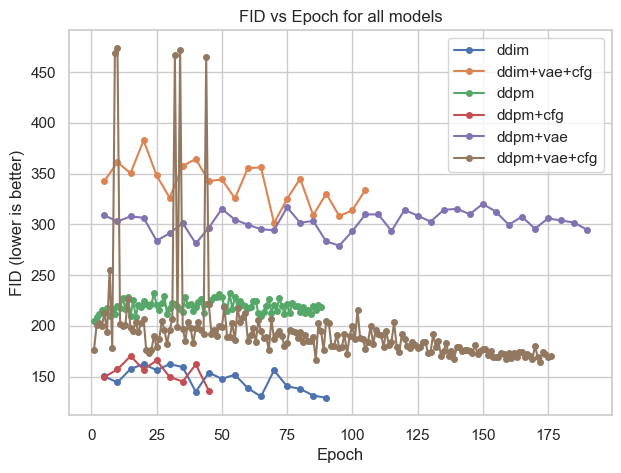

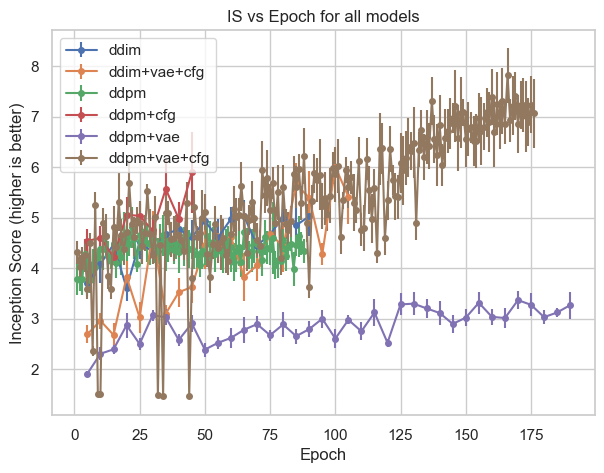

In [24]:


# FID vs epoch
plt.figure(figsize=(7,5))
for name, group in combined_df.groupby("model"):
    plt.plot(group["epoch"], group["fid"], marker="o", markersize=4, label=name)
plt.xlabel("Epoch")
plt.ylabel("FID (lower is better)")
plt.title("FID vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()

# IS vs epoch
plt.figure(figsize=(7,5))
for name, group in combined_df.groupby("model"):
    plt.errorbar(group["epoch"], group["is_mean"], yerr=group["is_std"], marker="o", markersize=4, label=name)
plt.xlabel("Epoch")
plt.ylabel("Inception Score (higher is better)")
plt.title("IS vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()


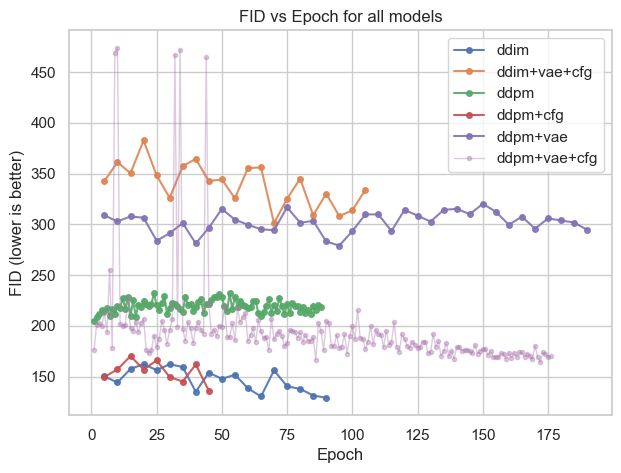

In [27]:
plt.figure(figsize=(7,5))

for name, group in combined_df.groupby("model"):

    # Custom lighter style for the heavy run
    if name == "ddpm+vae+cfg":
        plt.plot(
            group["epoch"],
            group["fid"],
            marker="o",
            markersize=3,
            alpha=0.4,                # lighten greatly
            linewidth=1.0,
            color="#ad78b08b",        
            label=name,
        )
    else:
        plt.plot(
            group["epoch"],
            group["fid"],
            marker="o",
            markersize=4,
            alpha=0.9,
            linewidth=1.5,
            label=name,
        )

plt.xlabel("Epoch")
plt.ylabel("FID (lower is better)")
plt.title("FID vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()


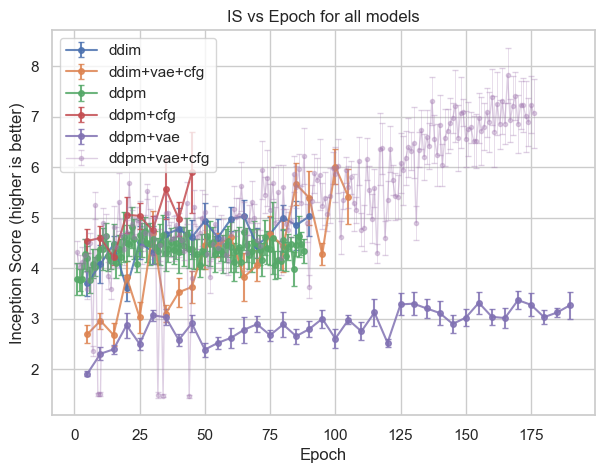

In [28]:
plt.figure(figsize=(7,5))

for name, group in combined_df.groupby("model"):

    # Special lighter styling for ddpm+vae+cfg (the heavy run)
    if name == "ddpm+vae+cfg":
        plt.errorbar(
            group["epoch"],
            group["is_mean"],
            yerr=group["is_std"],
            marker="o",
            markersize=3,
            alpha=0.35,               # very light curve
            linewidth=1.0,
            color="#a178b07f",  # light beige/brown
            elinewidth=0.5,
            capsize=2,
            label=name,
        )
    else:
        plt.errorbar(
            group["epoch"],
            group["is_mean"],
            yerr=group["is_std"],
            marker="o",
            markersize=4,
            alpha=0.85,
            linewidth=1.5,
            capsize=2,
            label=name,
        )

plt.xlabel("Epoch")
plt.ylabel("Inception Score (higher is better)")
plt.title("IS vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()
